# Zebrafish data analysis

## Library imports

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import scvelo as scv
import numpy as np
from typing import Optional, Tuple, Collection, Union, List,Literal

import torch

import scipy
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import wilcoxon

## Visualize the effects through the barplot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap
import mplscience

import anndata
from anndata import AnnData
from scvelo import logging as logg

import sys
import cellrank as cr
import os, shutil
sys.path.append("../..")
from paths import FIG_DIR, DATA_DIR

In [2]:
from regvelovi import REGVELOVI
from typing import Literal
from velovi import preprocess_data, VELOVI

/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0


## General setting

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=10, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'zebrafish' / 'benchmark' ,exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'zebrafish' / 'benchmark' ,exist_ok = True)

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

## Function defination

In [6]:
def sanity_check(
       adata,
    ) -> anndata.AnnData:
    
    gene_name = adata.var.index.tolist()
    full_name = adata.uns["regulators"]
    index = [i in gene_name for i in full_name]
    full_name = full_name[index]
    adata = adata[:,full_name].copy()

    W = adata.uns["skeleton"]
    W = W[index,:]
    W = W[:,index]

    adata.uns["skeleton"] = W 
    W = adata.uns["network"]
    W = W[index,:]
    W = W[:,index]
    #csgn = csgn[index,:,:]
    #csgn = csgn[:,index,:]
    adata.uns["network"] = W

    ###
    for i in range(1000):
        if adata.uns["skeleton"].sum(0).min()>0:
            break
        else:
            W = np.array(adata.uns["skeleton"])
            gene_name = adata.var.index.tolist()

            indicator = W.sum(0) > 0 ## every gene would need to have a upstream regulators
            regulators = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
            targets = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
            print("num regulators: "+str(len(regulators)))
            print("num targets: "+str(len(targets)))
            W = np.array(adata.uns["skeleton"])
            W = W[indicator,:]
            W = W[:,indicator]
            adata.uns["skeleton"] = W

            W = np.array(adata.uns["network"])
            W = W[indicator,:]
            W = W[:,indicator]
            adata.uns["network"] = W

            #csgn = csgn[indicator,:,:]
            #csgn = csgn[:,indicator,:]
            #adata.uns["csgn"] = csgn

            adata.uns["regulators"] = regulators
            adata.uns["targets"] = targets

            W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
            W = W.loc[regulators,targets]
            adata.uns["skeleton"] = W
            W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
            W = W.loc[regulators,targets]
            adata.uns["network"] = W
            adata = adata[:,indicator].copy()

    return adata

def add_regvelo_outputs_to_adata(adata_raw, vae):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/model_fit.ipynb
    # License: BSD-3-Clause license

    latent_time = vae.get_latent_time(n_samples=30, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

def add_outputs_to_adata(adata, vae):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/model_fit.ipynb
    # License: BSD-3-Clause license
    
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

In [7]:
def generate_sequence(k, n):
    sequence = list(range(1, k + 1))
    
    # If the length of the sequence is already >= n, trim it to n
    if len(sequence) >= n:
        return sequence[:n]
    
    # Fill the rest of the sequence with the number k
    sequence.extend([k] * (n - len(sequence)))
    
    return sequence
    
def stair_vec(kernel,threshold,terminal_states,cluster_key,all_dict,max_states = 12):
    pre_value = []
    for num_macro in range(1,max_states):
        try:
            # Append the result to the list
            kernel.compute_macrostates(n_states=num_macro,cluster_key=cluster_key)
            kernel.predict_terminal_states(stability_threshold=threshold)
            pre_terminal = kernel.terminal_states.cat.categories.tolist()
            subset_dict = {key: all_dict[key] for key in pre_terminal}
            pre_terminal_names = list(subset_dict.values())
            pre_terminal_names = list(set(pre_terminal_names))
            pre_value.append(len(set(pre_terminal_names).intersection(terminal_states)))
        except Exception as e:
            # Handle the error, print a message or take any other action
            print(f"Error: {e}")
            # Append 0 to the list as a placeholder for the error
            pre_value.append(pre_value[len(pre_value)-1])
        print(pre_value)
    return pre_value
    
def TSI_score(points,cluster_key,terminal_states,kernel,all_dict,max_states=12):
    x_values = range(0,max_states)
    y_values = [0]+generate_sequence(len(terminal_states),max_states-1)
    area_gs = 0
    for i in range(len(x_values) - 1):
        area_gs += (x_values[i + 1] - x_values[i]) * y_values[i]

    tsi_score = []
    for p in points:
        pre_value = stair_vec(kernel,p,terminal_states,cluster_key,all_dict,max_states)
        x_values = range(0,max_states)
        y_values = [0]+pre_value
        area_velo = 0
        for i in range(len(x_values) - 1):
            area_velo += (x_values[i + 1] - x_values[i]) * y_values[i]
        tsi_score.append(area_velo/area_gs)
    return tsi_score

In [8]:
def get_significance(pvalue):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: get_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license

    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: get_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license
    
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )

    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

In [9]:
def min_max_scaling(data):
    # Compute min and max values for each feature
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Perform min-max scaling
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    
    return scaled_data

def plot_states(
    adata,
    estimator,
    figsize,
    which: Literal["macrostates", "terminal_states"],
    basis: str,
    inplace: bool = False,
    fpath: Optional[str] = None,
    format: str = "png",
    dpi: Union[int, str] = "figure",
    **kwargs,
):
    # This code is adapted on an implementation by Marius Lange and Philipp Weilier et al. from their repository:
    # https://github.com/theislab/cellrank
    # Original function: plot_macrostates() in https://github.com/theislab/cellrank/blob/6b703342a0afb246b0b6784b780a1cfa98869725/src/cellrank/estimators/terminal_states/_term_states_estimator.py
    # License: BSD-3-Clause license
    
    if not inplace:
        adata = adata.copy()

    states = getattr(estimator, which).cat.categories.tolist()
    if which == "macrostates":
        states = estimator._macrostates
    elif which == "terminal_states":
        states = estimator._term_states
    state_names = states.assignment.cat.categories.tolist()

    adata.obs[which] = states.assignment.astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)
    if which == "macrostates":
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors
    else:
        adata.uns[f"{which}_colors"] = ["#dedede"] + states.colors.tolist()
    fig, ax = plt.subplots(figsize=figsize)
    scv.pl.scatter(
        adata,
        basis=basis,
        c=which,
        add_outline=state_names,
        ax=ax,
        **kwargs,
    )
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.42), ncol=2,frameon=False)

    if fpath is not None:
        fig.savefig(fpath, format=format, transparent=True, bbox_inches="tight", dpi=dpi)

In [10]:
def prior_GRN(adata, gt_net):
    regulator_index = [i in gt_net.columns for i in adata.var.index.values]
    target_index = [i in gt_net.index for i in adata.var.index.values]

    corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
    corr_m = torch.tensor(corr_m)
    corr_m = corr_m[target_index,]
    corr_m = corr_m[:,regulator_index]
    corr_m = corr_m.float()
    
    corr_m[np.isnan(corr_m)] = 0
    corr_m = pd.DataFrame(corr_m, index = adata.var.index.values[target_index], columns = adata.var.index.values[regulator_index])
    gt_net = gt_net.loc[corr_m.index,corr_m.columns]
    GRN_final = gt_net * corr_m
    GRN_final[abs(GRN_final)<0.01] = 0
    GRN_final[GRN_final!=0] = 1
    GRN_final = GRN_final.iloc[(GRN_final.sum(1) > 0).tolist(),(GRN_final.sum(0) > 0).tolist()]
    for i in GRN_final.columns:
        GRN_final.loc[i,i] = 0
    GRN_final = GRN_final.iloc[(GRN_final.sum(1) > 0).tolist(),(GRN_final.sum(0) > 0).tolist()]
    ### use the regulatory genes to perform velocity analysis
    genes = np.unique(GRN_final.index.tolist()+GRN_final.columns.tolist())
    W = torch.zeros((len(genes),len(genes)))
    W = pd.DataFrame(W,index = genes,columns = genes)
    W.loc[GRN_final.index.tolist(),GRN_final.columns.tolist()] = GRN_final
    
    adata = adata[:,genes].copy()
    W = W.loc[adata.var.index.values.tolist(),adata.var.index.values.tolist()]
       
    adata.uns["regulators"] = adata.var.index.values
    adata.uns["targets"] = adata.var.index.values
    adata.uns["skeleton"] = np.array(W)
    adata.uns["network"] = np.array(W)
    
    return adata

## Load datasets

In [11]:
## load smart-seq3 datasets
adata = sc.read_h5ad("RegVelo_datasets/zebrafish/adata_zebrafish_preprocessed.h5ad")
prior_net = pd.read_csv("RegVelo_datasets/zebrafish/prior_GRN.csv",index_col = 0)
TF_list = pd.read_csv("RegVelo_datasets/zebrafish/zebrafish_tfs.csv",index_col = 0)

In [12]:
TF_list = TF_list.iloc[:,0].tolist()

In [13]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)
#scv.pp.moments(adata, n_pcs=50, n_neighbors=30)

computing neighbors


2024-08-30 20:30:53.863949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


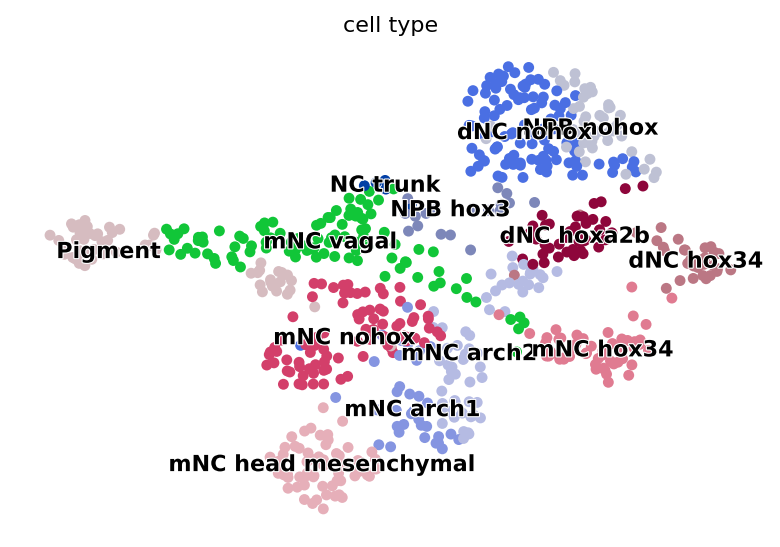

In [14]:
scv.pl.umap(adata, color='cell_type')

## Visaulize known terminal states

In [15]:
adata.obs["cell_type2"] = adata.obs["cell_type"].copy()
adata.obs["cell_type2"][~adata.obs["cell_type2"].isin(["NPB_nohox","mNC_hox34","Pigment","mNC_head_mesenchymal","mNC_arch2"])] = np.nan

In [16]:
adata.obs["cell_type2"] = adata.obs["cell_type2"].cat.remove_unused_categories()

In [17]:
palette = dict(zip(adata.obs["cell_type"].cat.categories, adata.uns["cell_type_colors"]))
subset_palette = {name: color for name, color in palette.items() if name in adata.obs["cell_type2"].cat.categories.tolist()}

In [18]:
list(subset_palette.values())

['#bec1d4', '#d6bcc0', '#b5bbe3', '#e6afb9', '#e07b91']

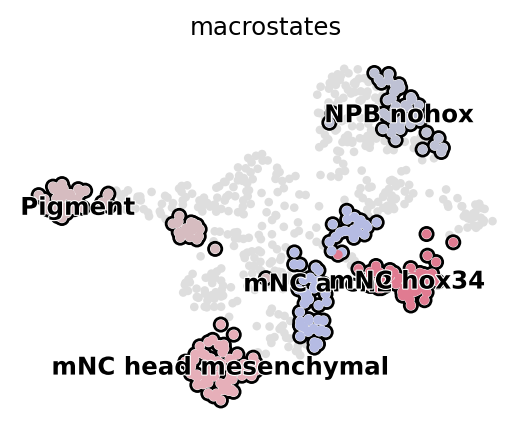

In [19]:
which = "macrostates"
adata.obs[which] = adata.obs["cell_type2"].copy()

state_names = adata.obs[which].cat.categories.tolist()
adata.obs[which] = adata.obs[which].astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)

if which == "macrostates":
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
else:
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
state_names = adata.obs[which].cat.categories.tolist()[1:]


with mplscience.style_context():
    fig, ax = plt.subplots(figsize = (4,3))
    scv.pl.scatter(
        adata,
        basis="umap",
        c=which,
        add_outline=state_names,
        ax=ax,
        size = 60,
    )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'zebrafish' / 'benchmark' / 'INTRO_figure.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

## Preprocessing

In [20]:
adata = prior_GRN(adata,prior_net)

/tmp/ipykernel_4966/665710336.py:11: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  corr_m[np.isnan(corr_m)] = 0


In [21]:
adata_raw = adata.copy()
adata

AnnData object with n_obs × n_vars = 697 × 1783
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage', 'cell_type2', 'macrostates'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'cell_type_colors', 'neighbors', 'macrostates_colors', 'regulators', 'targets', 'skeleton', 'network'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [22]:
adata = preprocess_data(adata,filter_on_r2 = True)
adata = sanity_check(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 986
num targets: 986
num regulators: 962
num targets: 962
num regulators: 952
num targets: 952


In [23]:
df = pd.read_csv("RegVelo_datasets/zebrafish/new_tf.csv",sep=";")
gene_list = np.unique(df.iloc[:,0].tolist() + adata.var_names.tolist())

In [24]:
gene_list = set(gene_list).intersection(adata_raw.var_names)
gene_list = list(gene_list)

In [25]:
adata.var["velocity_genes"].sum()

952

In [26]:
adata = adata_raw[:,gene_list].copy()
adata = preprocess_data(adata,filter_on_r2 = False)
scv.tl.velocity(adata)
adata = sanity_check(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 961
num targets: 961


In [27]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TF: "+str(len(TF_list)))

final number of TF: 73


In [28]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [29]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: "+str(np.array(sparsity)))

network sparsity: 0.060938235


## Training scVelo and veloVI model

In [30]:
adata_scv = adata.copy()
scv.tl.recover_dynamics(
        adata_scv, fit_scaling=False, var_names=adata_scv.var_names, n_jobs=8
    )
adata_scv.var["fit_scaling"] = 1.0
scv.tl.velocity(adata_scv, mode="dynamical", min_likelihood=-np.inf, min_r2=None)

recovering dynamics (using 8/64 cores)


  0%|          | 0/961 [00:00<?, ?gene/s]

/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:01:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [31]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 500/500: 100%|██████████| 500/500 [00:35<00:00, 15.30it/s, loss=-1.72e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:35<00:00, 14.08it/s, loss=-1.72e+03, v_num=1]


In [32]:
adata_velovi = adata.copy()
add_outputs_to_adata(adata_velovi, vae)

## Training RegVelo model

In [33]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,soft_constraint = False,regulators = TF_list)

In [34]:
reg_vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1341/1500:  89%|████████▉ | 1341/1500 [10:07<01:12,  2.21it/s, loss=-2.23e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2326.287. Signaling Trainer to stop.


In [35]:
adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)

In [36]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/64 cores)


  0%|          | 0/697 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


In [37]:
adata_target.obs["latent_time"] = min_max_scaling(adata_target.layers["fit_t"].mean(1))

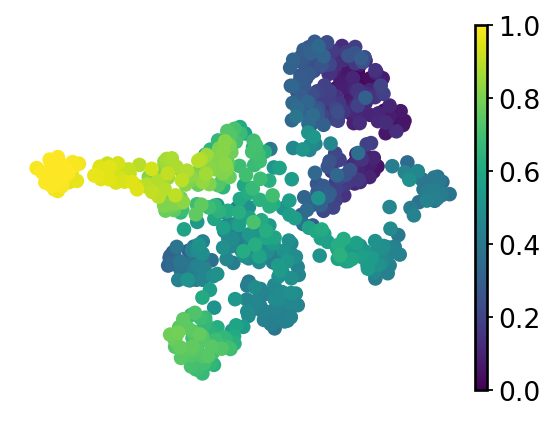

In [38]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize = (4,3))
    sc.pl.umap(
        adata = adata_target, 
        color="latent_time",
        title="",
        frameon = False,
        legend_fontsize = 14,
        ax = ax
    )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'zebrafish' / 'benchmark' / 'latent_time.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

In [39]:
df4 = pd.DataFrame({"stage":adata.obs["stage"].tolist(),
                   "latent_time":adata_target.obs["latent_time"].tolist()})

In [40]:
adata.obs["stage_num"] = 0
adata.obs["stage_num"][adata.obs["stage"].isin(["3ss"])] = 3
adata.obs["stage_num"][adata.obs["stage"].isin(["6-7ss"])] = 6.5
adata.obs["stage_num"][adata.obs["stage"].isin(["10ss"])] = 10
adata.obs["stage_num"][adata.obs["stage"].isin(["12-13ss"])] = 12.5
adata.obs["stage_num"][adata.obs["stage"].isin(["17-18ss"])] = 17.5
adata.obs["stage_num"][adata.obs["stage"].isin(["21-22ss"])] = 21.5

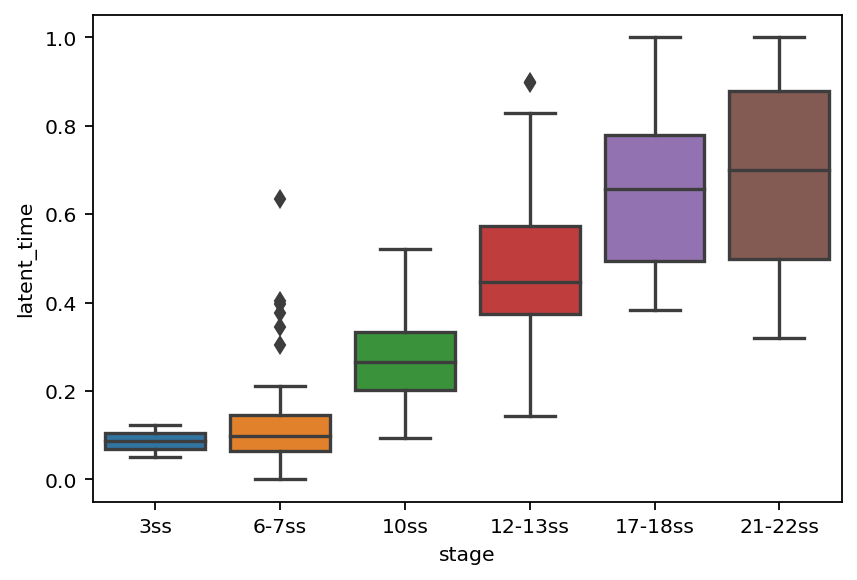

In [41]:
order = ["3ss","6-7ss","10ss","12-13ss","17-18ss","21-22ss"]
sns.boxplot(data = df4,x = "stage",y = "latent_time", order=order)
plt.show()

In [42]:
scipy.stats.spearmanr(adata.obs["stage_num"].tolist(),adata_target.obs["latent_time"].tolist())

SignificanceResult(statistic=0.7827120331914074, pvalue=2.8668793269867696e-145)

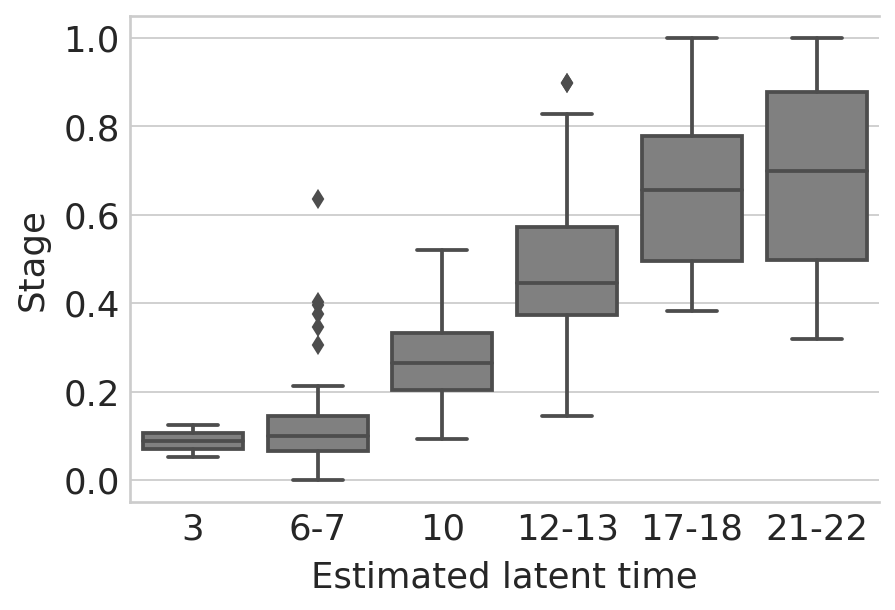

In [43]:
loc = [0, 1, 2, 3, 4,5]
#loc.reverse()
#loc
label = ["3","6-7","10","12-13","17-18","21-22"]

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6,4))
    order = ["3ss","6-7ss","10ss","12-13ss","17-18ss","21-22ss"]
    sns.boxplot(data = df4,x = "stage",y = "latent_time", order=order,color='grey',ax = ax)
    # Set labels and title
    plt.ylabel('Stage', fontsize=16)
    plt.xlabel('Estimated latent time', fontsize=16)

    # Enlarge the numbers on the axes
    #plt.gca().spines['top'].set_visible(False)  # Hide the top spine
    plt.gca().spines['right'].set_visible(False)  # Hide the right spine

    plt.xticks(ticks=loc, labels=label)  # Replace ticks with new labels
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    plt.show()
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'zebrafish' / 'benchmark' / 'latent_time_boxplot.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

In [44]:
### perform perturbation prediction
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

all_states = list(set(adata_target.obs["cell_type"].tolist()))

all_id = all_states.copy()
all_type = all_states.copy()
for i in all_states:
    for j in [1,2,3,4,5,6,7,8,9,10]:
        all_id.append(i+"_"+str(j))
        all_type.append(i)
all_dict = dict(zip(all_id, all_type))

In [45]:
## compute cellrank graph
n_states = 8
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states, n_cells = 30,cluster_key="cell_type")

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

GPCCA[kernel=VelocityKernel[n=697], initial_states=None, terminal_states=None]

In [46]:
g.set_terminal_states(terminal_states)

GPCCA[kernel=VelocityKernel[n=697], initial_states=None, terminal_states=['Pigment', 'mNC_arch2', 'mNC_head_mesenchymal', 'mNC_hox34']]

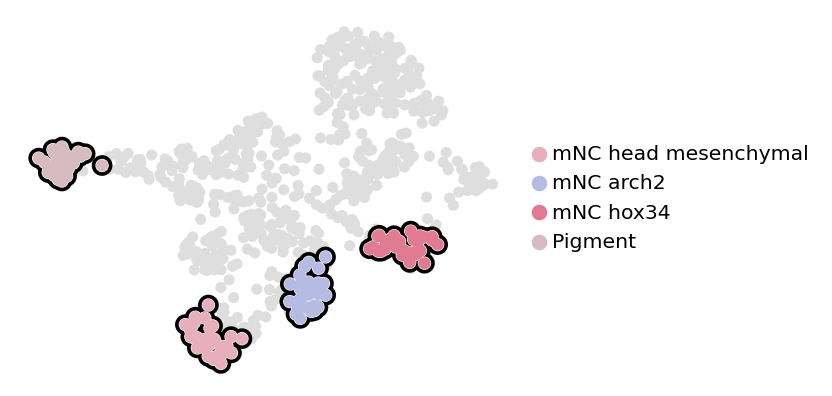

In [47]:
if SAVE_FIGURES:
    plot_states(
            adata_target,
            estimator=g,
            figsize = (4,3),
            which="terminal_states",
            basis="umap",
            legend_loc="right",
            title="",
            size=100,
            fpath = FIG_DIR / "zebrafish" / "benchmark" / "terminal_state.svg",
            dpi = 400,
            format = "svg"
        )

## Terminal state prediction benchmark

In [48]:
## build kernel matrix
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
rgv_g = cr.estimators.GPCCA(vk)

vk = cr.kernels.VelocityKernel(adata_velovi)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_velovi).compute_transition_matrix()
vi_g = cr.estimators.GPCCA(vk)

vk = cr.kernels.VelocityKernel(adata_scv)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_scv).compute_transition_matrix()
scv_g = cr.estimators.GPCCA(vk)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

In [49]:
points = np.linspace(0, 1, 21)[:20]
tsi_rgv = TSI_score(points,"cell_type",terminal_states,rgv_g,all_dict)
tsi_vi = TSI_score(points,"cell_type",terminal_states,vi_g,all_dict)
tsi_scv = TSI_score(points,"cell_type",terminal_states,scv_g,all_dict)

[1]
[1, 2]
[1, 2, 2]


[1, 2, 2, 2]
[1, 2, 2, 2, 3]


[1, 2, 2, 2, 3, 4]


[1, 2, 2, 2, 3, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]


[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]


[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 2]


[1, 2, 2, 3, 3, 3, 3, 3, 2, 2]


[1, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 2]


[1, 2, 2, 3, 3, 3, 3, 2, 1]


[1, 2, 2, 3, 3, 3, 3, 2, 1, 1]


[1, 2, 2, 3, 3, 3, 3, 2, 1, 1, 2]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 2, 2, 1]


[1, 2, 2, 2, 2, 2, 2, 2, 1, 1]


[1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 1]


[1, 2, 2, 2, 2, 1, 1]


[1, 2, 2, 2, 2, 1, 1, 1]


[1, 2, 2, 2, 2, 1, 1, 1, 1]


[1, 2, 2, 2, 2, 1, 1, 1, 1, 1]


[1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
[1]
[1, 2]
[1, 2, 1]
[1, 2, 1, 1]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 1, 1, 1]


[1, 2, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[1]
[1, 2]
[1, 2, 2]


[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]


[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3]


[1, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 3]


[1, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 2]


[1, 2, 2, 3, 3, 3, 2, 2]


[1, 2, 2, 3, 3, 3, 2, 2, 4]


[1, 2, 2, 3, 3, 3, 2, 2, 4, 3]


[1, 2, 2, 3, 3, 3, 2, 2, 4, 3, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 2]


[1, 2, 2, 3, 3, 3, 2, 2]


[1, 2, 2, 3, 3, 3, 2, 2, 3]


[1, 2, 2, 3, 3, 3, 2, 2, 3, 2]


[1, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 3]


[1, 2, 2, 3, 3, 3]


[1, 2, 2, 3, 3, 3, 2]


[1, 2, 2, 3, 3, 3, 2, 2]


[1, 2, 2, 3, 3, 3, 2, 2, 3]


[1, 2, 2, 3, 3, 3, 2, 2, 3, 2]


[1, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]


[1, 2, 2, 3, 2]


[1, 2, 2, 3, 2, 2]


[1, 2, 2, 3, 2, 2, 2]


[1, 2, 2, 3, 2, 2, 2, 2]


[1, 2, 2, 3, 2, 2, 2, 2, 2]


[1, 2, 2, 3, 2, 2, 2, 2, 2, 2]


[1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]


[1, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 1]


[1, 2, 2, 2, 2, 2, 1, 1]


[1, 2, 2, 2, 2, 2, 1, 1, 2]


[1, 2, 2, 2, 2, 2, 1, 1, 2, 2]


[1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]


[1, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 1]


[1, 2, 2, 2, 2, 2, 1, 1]


[1, 2, 2, 2, 2, 2, 1, 1, 2]


[1, 2, 2, 2, 2, 2, 1, 1, 2, 2]


[1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1]
[1]
[1, 2]
[1, 2, 1]
[1, 2, 1, 1]


[1, 2, 1, 1, 1]


[1, 2, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1, 1]


[1, 2, 1, 1, 1, 1, 1, 1, 2]


[1, 2, 1, 1, 1, 1, 1, 1, 2, 2]


[1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]


[1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1, 2]


[1, 1, 1, 1, 1, 1, 1, 1, 2, 2]


Error: No macrostates have been selected.
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]


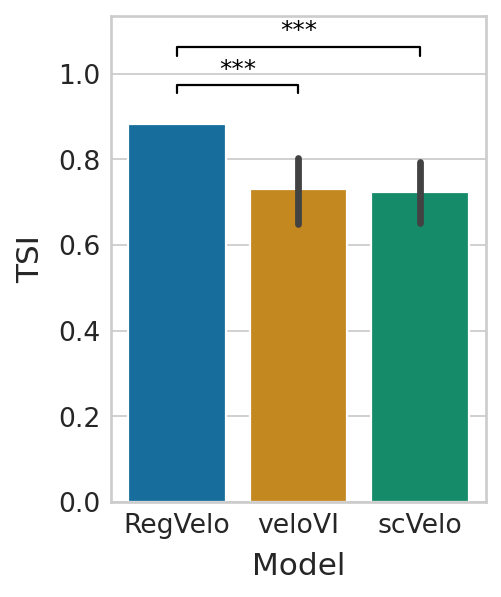

In [50]:
df = pd.DataFrame(
    {
        "TSI":  tsi_rgv + tsi_vi + tsi_scv,
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20
    }
)        
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)
    
    ttest_res = wilcoxon(tsi_rgv, tsi_vi, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = wilcoxon(tsi_rgv, tsi_scv, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    
    #ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    #ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0]);
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "zebrafish" / "benchmark" / "TSI_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

In [51]:
pre_value_rgv = stair_vec(rgv_g,0.8,terminal_states,"cell_type",all_dict)
pre_value_vi = stair_vec(vi_g,0.8,terminal_states,"cell_type",all_dict)
pre_value_scv = stair_vec(scv_g,0.8,terminal_states,"cell_type",all_dict)

[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 4]
[1, 2, 2, 2, 3, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4]


[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]


Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 2, 2, 1]


[1, 2, 2, 2, 2, 2, 2, 2, 1, 1]


[1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]


[1, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2]


[1, 2, 2, 2, 2, 2, 1]


[1, 2, 2, 2, 2, 2, 1, 1]


[1, 2, 2, 2, 2, 2, 1, 1, 2]


[1, 2, 2, 2, 2, 2, 1, 1, 2, 2]


[1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2]


### RegVelo identify all four terminal states

In [52]:
### plot the recovery figure
df = pd.DataFrame({"number_macrostate":range(0,12),
                   "RegVelo":[0]+pre_value_rgv,
                   "veloVI":[0]+pre_value_vi,
                   "scVelo":[0]+pre_value_scv})

In [53]:
df = pd.melt(df, ['number_macrostate'])
colors = sns.color_palette("colorblind", n_colors=3)
colors = colors + [(0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

/tmp/ipykernel_4966/2613435201.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)


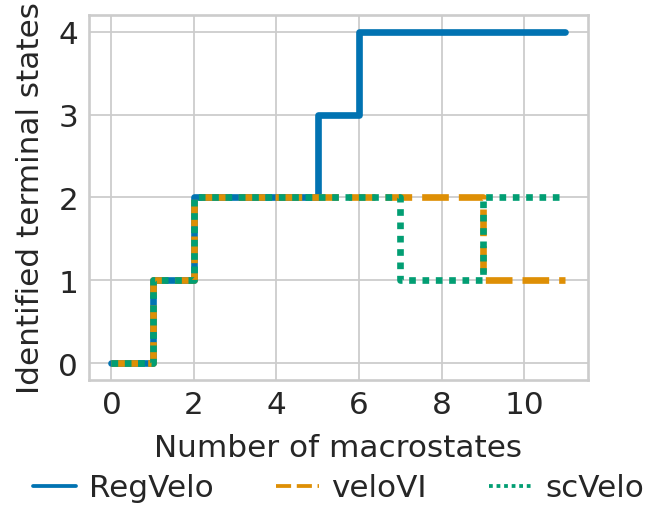

In [54]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    
    rcParams['figure.figsize'] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)

    # Set labels and titles
    ax.set(ylabel='Number of correct predictions')
    plt.xlabel('Number of macrostates', fontsize=14)
    plt.ylabel('Identified terminal states', fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2,4,6,8,10])
    ax.set_xticklabels([0, 2,4,6,8,10]);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4,fontsize = 14)

    if SAVE_FIGURES:
        plt.savefig(
                FIG_DIR / "zebrafish" / "benchmark" / "state_identification.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    plt.show()

In [55]:
adata_target.var["TF"] = [i in TF_list for i in adata_target.var_names]

In [56]:
if SAVE_DATASETS:
    adata_target.write_h5ad(DATA_DIR / 'zebrafish' / 'zebrafish_analysis.h5ad')
    reg_vae.save(DATA_DIR / 'zebrafish' / 'rgv_model_0')